# Machine Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from nltk.stem.porter import PorterStemmer
import re
import pickle

import warnings


%matplotlib inline
pd.set_option("display.max_columns", None)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:\\Users\\jltsa\\Desktop\\Cust_complaints\\feature_sets\\ml_data1.csv')

In [3]:
df.head()

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company,submitted_via,timely_response
0,Credit card,None,Billing statement,None,Year end summary provided by citi shows balanc...,"CITIBANK, N.A.",Web,True
1,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,I received a letter from a debt collector clai...,"Amsher Collection Services, Inc.",Web,True
2,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,I HAVE SUBMITTED COMPLAINTS TO OF UPSTATE NY C...,"Credit Protection Association, L.P.",Web,True
3,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt resulted from identity theft,has accounts in my name that were fraudulently...,"Convergent Resources, Inc.",Web,True
4,Credit card,None,Late fee,None,When making online through personal bank payme...,SYNCHRONY FINANCIAL,Web,True


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383840 entries, 0 to 383839
Data columns (total 8 columns):
product                         383840 non-null object
sub_product                     383840 non-null object
issue                           383840 non-null object
sub_issue                       383840 non-null object
consumer_complaint_narrative    383840 non-null object
company                         383840 non-null object
submitted_via                   383840 non-null object
timely_response                 383840 non-null bool
dtypes: bool(1), object(7)
memory usage: 20.9+ MB


## Measuring Success

In [10]:
df.groupby('timely_response').count()['company'].sort_values(ascending=False)

timely_response
True     372452
False     11388
Name: company, dtype: int64

In [11]:
11388/(372452+11388)

0.029668611921634013

Because the data has only around 3% of the labels calssified as False or not responsign appropriately in time, accuracy will be a bad metric of success.  For instance, the model can classify everything as True and have an accuracy rate of 97%.

Instead, we can use log loss as a measure of success.  It is actually a measure of error.  In this case we want log loss to be as small as possible as opposed to accuracy.

Oen take away is that it isbetter to be less confident than confident and wrong about a prediction.

In [3]:
# Log loss can be calculated with numpy
def compute_log_loss(predicted, actual, eps=1e-14):
    """
    predicted: probabilities as floats between 0 and 1
    actual: binary labels, 0=no or 1=yes
    eps: log(0) is inf, need to offset predicted values by eps from 0 to 1
    """
    predicted = np.clip(predicted, eps, 1- eps)
    loss = -1 * np.mean(actual * np.log(predicted) + (1 - actual)
              * np.log(1 - predicted))
    return loss

In [15]:
#we are saying we are predicting the value is 1 with 90% probability
#But the the actual label is 0
compute_log_loss(predicted=0.9, actual=0)

2.302585092994046

In [33]:
#scikit-learn implementation
log_loss([0,1], [0.9, 0.1])

2.302585092994046

In [18]:
#Predicting 50% probability that value is 1
#Actual label is 1
compute_log_loss(0.5, 1)

0.6931471805599453

## Possible Features to Engineer?

1. A count for number of exclamation points in a narrative - could be an indicator of how important a claim can be

## Splitting Data into Training and Test Sets

As noted above the False label only appears in about 3% of our data.  We need to make sure the training and test splits include these labels.  We can use StratifiedShuffleSplit from SciKitLearn.

## Preprocessing Data
We did some preprocessing already on the data.  Now, we will do further preprocessing to get our data for machine learning.  For this project, use a bag of words representation for NLP.

In [3]:
#tokenizer
spacy.load('en_core_web_sm')
lemmatizer = spacy.lang.en.English()
porter_stemmer = PorterStemmer()

In [4]:
#Used for testing output of vectorizer
def wm2df(wm, feat_names):
    #create a dataframe from a word matrix
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

In [5]:
#Customizing Vectorizers stemming
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

#Customizing Vectorizers lemmatization
def my_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens])

custom_vec = CountVectorizer(tokenizer=my_tokenizer,
                             ngram_range=(1,2),
                             stop_words='english')

In [6]:
#labels we want to predict
labels = df['timely_response'].values

In [7]:
#drop the label for the Data so we can pull out only the features
df = df.drop('timely_response', axis=1)

In [8]:
#convert all features but complaint narrative to dummy variables
cats = ['product', 'sub_product', 'issue', 'sub_issue', 'company', 'submitted_via']

#df = pd.get_dummies(df, columns=cats)

In [9]:
#Use Function transformer to create steps to vectorize narrative data
def get_narr(df):
    return df['consumer_complaint_narrative']

#grabs the complaint narrative data for use in pipe line
get_narr_pl = FunctionTransformer(get_narr, validate=False)

def get_cats(df):
    return df[['product', 'sub_product', 'issue', 'sub_issue', 'company', 'submitted_via']]

get_cats_pl = FunctionTransformer(get_cats, validate=False)

## Train and Test Sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=.25, random_state=42)

## Model Training

### Random Forest - default hyper parameters

In [70]:
pl = Pipeline([
             ('union', FeatureUnion(
                  transformer_list = [
                      ('cat_features', Pipeline([
                          ('selector', get_cats_pl),
                          ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))
                      ])),
                      ('narr_feature', Pipeline([
                          ('selector', get_narr_pl),
                          ('vecorizer', custom_vec)
                      ]))
                  ])),
             ('clf', RandomForestClassifier())
               ])

In [71]:
pl.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('cat_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function get_cats at 0x0000027D13C3E378>, inv_kw_args=None,
          inverse_func=None, kw...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [72]:
proba = pl.predict_proba(X_test)

In [73]:
#log loss
log_loss(y_test, proba)

0.5127938367308402

In [74]:
#accuracy
pl.score(X_test, y_test)

0.9699979157982492

In [75]:
#Classification Report
rf_predict = pl.predict(X_test)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

       False       0.44      0.05      0.08      2843
        True       0.97      1.00      0.98     93117

   micro avg       0.97      0.97      0.97     95960
   macro avg       0.71      0.52      0.53     95960
weighted avg       0.96      0.97      0.96     95960



For this model we are more concerned about predicting the False values because they are only about 3% of the data.  48% precision for False means the model predicts a False, it is identifying it correctly 48% of the time.  The recall of 5% is low, meaning that the model over predicts 5% of False correctly.  The goal is to get this higher.

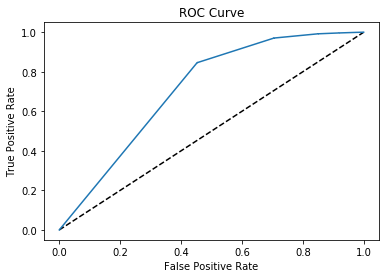

In [76]:
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])
#plot ROC curve
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [77]:
#area under curve
auc(fpr, tpr)

0.7123553796259428

In [78]:
#F1 score
f1_score(y_test, rf_predict)

0.9847495245813933

### Random Forest (Stemming) - tuning hyper parameters

In [79]:
#Hyper Parameters
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 3, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]

param_grid = {'clf__n_estimators': n_estimators,
              'clf__max_features': max_features,
              'clf__max_depth': max_depth,
              'clf__min_samples_split': min_samples_split,
              'clf__min_samples_leaf': min_samples_leaf,
              'clf__bootstrap': bootstrap}

In [80]:
#Initialize Pipeline
pl2 = Pipeline([
             ('union', FeatureUnion(
                  transformer_list = [
                      ('cat_features', Pipeline([
                          ('selector', get_cats_pl),
                          ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))
                      ])),
                      ('narr_feature', Pipeline([
                          ('selector', get_narr_pl),
                          ('vecorizer', custom_vec)
                      ]))
                  ])),
             ('clf', RandomForestClassifier())
               ])

In [82]:
#Randomized search of hyperparameters
rf_param_search = RandomizedSearchCV(pl2, param_distributions=param_grid)

In [83]:
rf_param_search.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('cat_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function get_cats at 0x0000027D13C3E378>, inv_kw_args=None,
          inverse_func=None, kw...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'clf__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'clf__max_features': ['auto', 'sqrt'], 'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'clf__min_samples_split': [2, 3, 5, 10], 'clf__min_samples_leaf': [1, 2, 3, 4], 'clf__bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn'

In [99]:
'''

#Just the best estimator
optimised_rf = rf_param_search.best_estimator_


file_name1 = 'optimised_rf_estimator.pickle'
with open('models\\'+file_name1, 'wb') as file1:
    pickle.dump(optimised_rf, file1)
    
file_name2 = 'optimised_rf_fullsearch.pickle'
with open('models\\'+file_name2, 'wb') as file2:
    pickle.dump(rf_param_search, file2)
'''

"\n#Save model\nimport pickle\n#pickle the model\n\n#Just the best estimator\noptimised_rf = rf_param_search.best_estimator_\n\n\nfile_name1 = 'optimised_rf_estimator.pickle'\nwith open('models\\'+file_name1, 'wb') as file1:\n    pickle.dump(optimised_rf, file1)\n    \nfile_name2 = 'optimised_rf_fullsearch.pickle'\nwith open('models\\'+file_name2, 'wb') as file2:\n    pickle.dump(rf_param_search, file2)\n"

In [89]:
#Best Parameters for tuned random forest model
rf_param_search.best_params_

{'clf__n_estimators': 20,
 'clf__min_samples_split': 5,
 'clf__min_samples_leaf': 2,
 'clf__max_features': 'auto',
 'clf__max_depth': 10,
 'clf__bootstrap': False}

In [90]:
rf_param_search.best_index_

0

In [91]:
rf_param_search.cv_results_

{'mean_fit_time': array([645.63081106, 603.43199539, 593.71129656, 623.42822138,
        587.12391353, 600.12615172, 580.06843607, 578.33739392,
        583.6688242 , 579.85766927]),
 'std_fit_time': array([51.56299344,  1.3173086 ,  0.4785153 ,  1.44013131,  1.94726149,
         2.17525346,  3.06342235,  2.98308713,  1.58013677,  3.27574194]),
 'mean_score_time': array([327.22101061, 290.21437422, 284.55165863, 293.73564331,
        283.02891024, 295.72832799, 280.70311538, 281.35241437,
        288.9407781 , 281.97540355]),
 'std_score_time': array([30.75767898,  1.36850203,  1.2769552 ,  1.78262412,  0.73471728,
         2.21073922,  1.72673697,  1.27961408,  1.32093753,  3.78755191]),
 'param_clf__n_estimators': masked_array(data=[20, 70, 30, 80, 20, 90, 10, 10, 60, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_clf__min_samples_split': masked_array(data=

In [92]:
proba_rf = rf_param_search.predict_proba(X_test)

In [93]:
#log loss
log_loss(y_test, proba_rf)

0.1305578651165261

In [94]:
#accuracy
rf_param_search.score(X_test, y_test)

0.9703730721133805

In [95]:
#Classification Report
rf_tuned_predict = rf_param_search.predict(X_test)
print(classification_report(y_test, rf_tuned_predict))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2843
        True       0.97      1.00      0.98     93117

   micro avg       0.97      0.97      0.97     95960
   macro avg       0.49      0.50      0.49     95960
weighted avg       0.94      0.97      0.96     95960



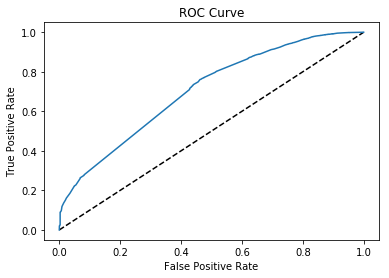

In [96]:
fpr, tpr, thresholds = roc_curve(y_test, proba_rf[:,1])
#plot ROC curve
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [97]:
auc(fpr, tpr)

0.703802548249325

### Random Forest (Lemmatizing) - tuning hyper parameters

Not shown in this notebook was the RandomizedGridSearchCV that led to the parameters set in the RandomForest clf below.

In [13]:
#Initialize Pipeline
pl3 = Pipeline([
             ('union', FeatureUnion(
                  transformer_list = [
                      ('cat_features', Pipeline([
                          ('selector', get_cats_pl),
                          ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))
                      ])),
                      ('narr_feature', Pipeline([
                          ('selector', get_narr_pl),
                          ('vecorizer', custom_vec)
                      ]))
                  ])),
             ('clf', RandomForestClassifier(n_estimators=80, min_samples_split=10,
                                            min_samples_leaf=1, max_features='auto',
                                            max_depth=None, bootstrap=True))
               ])

In [14]:
pl3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('cat_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function get_cats at 0x00000271DBB5D048>, inv_kw_args=None,
          inverse_func=None, kw...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [15]:
#file_name1 = 'optimised_rf_estimator.pickle'
#with open('models\\'+file_name1, 'wb') as file1:
    #pickle.dump(pl3, file1)

In [16]:
proba = pl3.predict_proba(X_test)

In [17]:
#log loss
log_loss(y_test, proba)

0.11380776743705874

In [18]:
#accuracy
pl3.score(X_test, y_test)

0.9707169654022509

In [19]:
#Classification Report
rf_predict = pl3.predict(X_test)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

       False       0.71      0.02      0.04      2843
        True       0.97      1.00      0.99     93117

   micro avg       0.97      0.97      0.97     95960
   macro avg       0.84      0.51      0.51     95960
weighted avg       0.96      0.97      0.96     95960



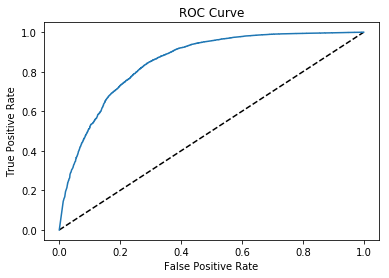

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])
#plot ROC curve
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [21]:
#area under curve
auc(fpr, tpr)

0.8519842307774698

### Feature Importance

## Logistic Regression (Lemmatization)

In [13]:
pl4 = Pipeline([
             ('union', FeatureUnion(
                  transformer_list = [
                      ('cat_features', Pipeline([
                          ('selector', get_cats_pl),
                          ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))
                      ])),
                      ('narr_feature', Pipeline([
                          ('selector', get_narr_pl),
                          ('vecorizer', custom_vec)
                      ]))
                  ])),
             ('clf', LogisticRegression())
               ])

In [23]:
pl4.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('cat_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function get_cats at 0x00000271DBB5D048>, inv_kw_args=None,
          inverse_func=None, kw...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [24]:
proba = pl4.predict_proba(X_test)

In [25]:
#log loss
log_loss(y_test, proba)

0.1043034372541695

In [26]:
#accuracy
pl4.score(X_test, y_test)

0.9710921217173822

In [27]:
#Classification Report
rf_predict = pl4.predict(X_test)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

       False       0.56      0.11      0.18      2843
        True       0.97      1.00      0.99     93117

   micro avg       0.97      0.97      0.97     95960
   macro avg       0.77      0.55      0.58     95960
weighted avg       0.96      0.97      0.96     95960



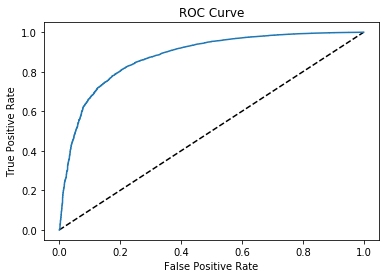

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])
#plot ROC curve
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [29]:
#area under curve
auc(fpr, tpr)

0.8784118736457299

## Hyper Tuning Logistic Regression

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {'clf__penalty': ['l1','l2'],
                 'clf__C': np.logspace(-4, 4, 12)}


In [14]:
lr_grid_search = GridSearchCV(pl4, param_grid_lr, cv=3)

In [ ]:
lr_grid_search.fit(X_train, y_train)